# Machine Learning using Best Fourier Coefficients


### Importing the data 

In [23]:
import h5py                                     # Importing the h5 package.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PyDynamic  


In [24]:
from PyDynamic import __version__ as version
version

'1.2.78'

In [25]:
filename = 'Sensor_data_2kHz.h5'                # Data filename.
f = h5py.File(filename, 'r')                    # Importing the h5 file. 

#print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

data = list(f[a_group_key])                     # Transforming data into list

sensorADC=[]                                       # Initialising a list "sensor" and
for i in range(11):                                # Filling it with data from all sensors 
    sensorADC.append(pd.DataFrame(data[i][:][:]))

for i in range(11):                             
    sensorADC[i]=sensorADC[i].iloc[:,:6291]           # Cuting the last cycle because it contains all zero elements.

print("""    
    Input matrices have dimensions: %s, where %s represents number of measurements in time
    and %s represents number of cycles.""" % (np.shape(sensorADC[0]),np.shape(sensorADC[0])[0],np.shape(sensorADC[0])[1]))

    
    Input matrices have dimensions: (2000, 6291), where 2000 represents number of measurements in time
    and 6291 represents number of cycles.


### Converting into SI units 

In [26]:
offset=[0, 0, 0, 0, 0.00488591, 0.00488591, 0.00488591,  0.00488591, 1.36e-2, 1.5e-2, 1.09e-2]
gain=[5.36e-9, 5.36e-9, 5.36e-9, 5.36e-9, 3.29e-4, 3.29e-4, 3.29e-4, 3.29e-4, 8.76e-5, 8.68e-5, 8.65e-5]
b=[1, 1, 1, 1, 1, 1, 1, 1, 5.299641744, 5.299641744, 5.299641744]
k=[250, 1, 10, 10, 1.25, 1, 30, 0.5, 2, 2, 2]
units=['[Pa]', '[g]', '[g]', '[g]', '[kN]', '[bar]', '[mm/s]', '[A]', '[A]', '[A]', '[A]']

sensor=[0]*len(sensorADC)

for i in range(len(sensorADC)):
    sensor[i]=((sensorADC[i]*gain[i])+offset[i])*b[i]*k[i]


###### If you have problems with previous step, you can skip conversion into SI units by runing next cell.

In [5]:
sensor=sensorADC

### Splitting data into training and testing data

Lifetime is represented with percentage values where 0 % means being brand-new and 100 % being broken. Firstly, target vector is created, which assumes linear correlation between cycle number and the degree of wear of the electro-mechanical cylinder.

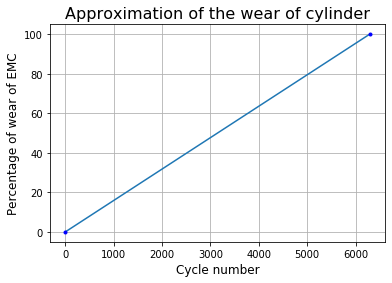

In [27]:
# Creating a target vector which will be used for correlation analysis.

target=list(np.zeros(6291))          # Making the target list which takes into account number of cycles, which-
for i in range(6291):                # goes from 0 to 100, and has number of elements same as number of cycles. 
    target[i]=(i/6290)*100

target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target matrix "
plt.plot(target_matrix.index.values, target_matrix.values)
plt.title("Approximation of the wear of cylinder", fontsize=16)
plt.xlabel("Cycle number", fontsize=12)
plt.ylabel("Percentage of wear of EMC", fontsize=12)
plt.grid()
plt.plot(6291, 100, '.', color='b')
plt.plot(0, 0, '.', color='b')

Now we need to split the raw data into training and testing data sets.
For that purpose, we use scikit.learn function `train_test_split` which will, in this case, choose randomly k % of the cycles into training data, and the rest of it will be used for testing. Function `train_test_split` is applied on target vector, and based on a selected cycles for training and testing in target vector, those same cycles are extracted from the data set `"sensor"`.

So, after this step main data to work on are lists: 

"sensor_train" with their class labels "train_target"
 
and 
 
"sensor_test" with their class labels "test_target"

In [28]:
from sklearn.model_selection import train_test_split

k = int(input("Enter the percentage which will be used as a traning data (recommended is 80-90): "))
target_train_vector, target_test_vector =train_test_split(target_matrix, test_size=1-k/100.)

print("\nNumber of cycles selected for traning is: ", target_train_vector.shape[0],",")
print("and number of cycles selected for testing is: ", target_test_vector.shape[0])

target=list(target_train_vector[0])


Enter the percentage which will be used as a traning data (recommended is 80-90): 85

Number of cycles selected for traning is:  5347 ,
and number of cycles selected for testing is:  944


In [29]:
sensor_train=[0]*11
sensor_test=[0]*11

for i in range(11):
    sensor_train[i]=sensor[i].loc[:,target_train_vector.index]

print("Traning data for one sensor has dimensions: ", sensor_train[10].shape,",      ('sensor_train') ")
print("and it's target vector has length: ", target_train_vector.shape,",               ('target_train_vector') \n")

for i in range(11):
    sensor_test[i]=sensor[i].loc[:,target_test_vector.index]

print("Testing data for one sensor has dimensions: ", sensor_test[10].shape,",      ('sensor_test') ")
print("and it's target vector has length: ", target_test_vector.shape,",        ('target_test_vector') \n")

Traning data for one sensor has dimensions:  (2000, 5347) ,      ('sensor_train') 
and it's target vector has length:  (5347, 1) ,               ('target_train_vector') 

Testing data for one sensor has dimensions:  (2000, 944) ,      ('sensor_test') 
and it's target vector has length:  (944, 1) ,        ('target_test_vector') 



We can have a look at the data from one sensor after splitting for better understanding of structure for next steps. Number of rows is 2000 and each column is one random measurement cycle. Table shows only first five samples in time (five rows) for each cycle. 

In [30]:
sensor_train[0].head()

,2048,954,6178,2395,690,5637,4230,4581,3742,6234,...,2373,4843,4941,2292,2754,5771,659,401,4069,6127
0,-0.015414,0.082119,0.212961,0.101607,0.120367,0.129027,0.057833,0.096556,0.083628,0.008979,...,0.067678,-0.001184,-0.133071,0.087543,0.147155,-0.033729,0.084670,-0.001993,0.042904,0.141332
1,0.151699,-0.143913,0.082494,0.246533,0.048277,0.015762,0.233384,0.078930,0.100760,0.226465,...,-0.066574,0.266913,0.077431,0.105903,0.115677,0.260336,-0.153962,-0.148586,0.124783,0.017789
2,0.077660,-0.159567,0.079416,0.172415,0.026222,0.119203,0.157326,-0.049755,-0.151176,-0.003077,...,-0.057839,0.027670,-0.256170,0.185924,0.063964,0.094303,-0.095391,-0.084839,0.203134,-0.014125
3,0.076790,-0.000500,-0.113889,0.101034,0.221372,-0.000010,0.174316,0.208084,0.101030,-0.027019,...,0.053913,0.201736,-0.143001,0.164798,0.057749,0.309854,-0.057356,-0.065746,0.120882,0.092809
4,0.128682,0.207634,0.045806,0.099763,0.047584,0.266500,0.135423,0.102263,-0.016239,0.007939,...,-0.069036,0.337455,-0.339274,0.113665,-0.064267,0.087791,-0.024084,-0.125328,0.066557,0.127520


## Feature selection 
### Feature selection using Pearson correlation coefficients

After all these unsupervised steps, this step is done with knowledge of cycle‘s group affiliation. Selection is based on a target vector which represents label for each cycle. The method is very simple, Pearson correlation coefficient is calculated between selected features and target vector and it is done for all sensors. After that, number of features with overall highest Pearson correlation coefficients is selected.

#### Pearson correlation

A Pearson correlation is a number between -1 and 1 that indicates the extent to which two variables are linearly related. A correlation coefficient indicates the extent to which dots in a scatterplot lie on a straight line. The stronger the association of the two variables, the closer the Pearson correlation coefficient, r, will be to either +1 or -1 depending on whether the relationship is positive or negative, respectively.

_Pearson correlation formula [3]:_

<img src="pictures/formula1.png">

- $x$ and $y$ are two vectors of length n
- $m_x$ and $m_y$ corresponds to the means of x and y, respectively.

Different relationships and their correlation coefficients are shown in the figure below [4]:

<img src="pictures/Correlation_examples.png">

Firstly, correlation coefficients are calculated for all features and their values are stored in the list `corr`. Then, function called `largest_indices` finds indices for wanted amount of features with highest correlation coefficients. Function output is stored into lists 'sensor_n' and 'feature_n', where element in 'sensor_n' means which sensor, and related element in 'feature_n' means which feature of that sensor is accessed.

Example:
If element in 'sensor_n' is 5, and the element in 'feature_n' at the same position is 50, that means that you can access that feature in this way:

``` python
    sorted_values_from_all_sensors[5].iloc[:][50]
```


*Reading the sorted data for 10% of the highest amplitudes from the file Machine_Learning_using_Best_Fourier_Coefficients.ipynb calculated from FFT:*

In [31]:
import os
import h5py

amp_fft1= h5py.File("Sorted_vaules_from_all_sensors3.hdf5","r")
freq_fft1= h5py.File("Sorted_freq_from_all_sensors3.hdf5","r")    


In [32]:
freq_of_sorted_values=[0]*len(sensor_train)
sorted_values_from_all_sensors=[0]*len(sensor_train)
for i in range(len(sensor)):
    freq_of_sorted_values[i]=freq_fft1["freq_of_sorted_values"+str(i)]
    sorted_values_from_all_sensors[i]=amp_fft1["sorted_values_from_all_sensors"+str(i)]
ampfft1.close()
freq_fft1.close()

In [33]:
from scipy.stats import pearsonr
N=10 #percentage of highest amplitudes, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb
n_of_samples=2000 #number of samples, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb

n_features_for_select=0
for i in range(len(sorted_values_from_all_sensors)):
    n_features_for_select=n_features_for_select+int(len(sorted_values_from_all_sensors[i][0][:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select))


target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target_matrix"

print("\nDimension of target matrix is:")
print("                                                 ", target_train_vector.shape)
print("Dimension of amplitude matrix for one sensor is:")
print("                                                 ", sorted_values_from_all_sensors[0][:,:].shape)

corr=list(range(11))                      # Making list for correlation coefficients.
p_value=list(range(11))

for j in range(11):                       # Making sublists in "corr" for each sensor.
    corr[j]=list(range(round((N/100.0)*n_of_samples/2)))
    p_value[j]=list(range(round((N/100.0)*n_of_samples/2)))
    
# Calculating correlation coefficients for each column of each sensor with respect to target.
for j in range(11):
    for i in range(round((N/100.0)*n_of_samples/2)):
        corr[j][i],p_value[j][i]=pearsonr(np.abs(sorted_values_from_all_sensors[j][:,i]),target_train_vector[0])

#matrix_corr_coeff = np.transpose(pd.DataFrame(corr))# Transforming list of correlation coefficients to data frame.
corr_array=np.array(corr)                                   # Transforming list of correlation coefficients to nparray

print("Array of correlation coefficients has size:")
print("                                                 ",corr_array.shape)  

def largest_indices(array, n):                               # Function that find indices for 500 biggest Pearson-
    """Returns the n largest indices from a numpy array."""  # -correlation coefficients.
    flat = array.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, array.shape)  

# sensor_n is the index of the sensor number.
# feature_n is the index of the feature number for each sensor number.
sensor_n, feature_n = largest_indices(corr_array, n_of_features)

print("Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
print(sensor_n)
print("\nColumn indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
print(feature_n)

How many features out of 1100 you want to select (recommended is 500): 500

Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients has size:
                                                  (11, 100)
Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: 

[ 1  5  5  5  1  5 10  9  2  1 10  8  9  6  6 10  1  0  8  9  0 10  1  1
  9  9  5  9  7  6  5  5  8  6  1  1  5  6  7  1  8  3 10  6  3  0  5 10
  6 10  6  8  6 10  0  0 10  1  2  8  9  1 10  5 10  9 10  5  9  8  8  5
  9  6 10  5  5  2  1  8  7  1  2  3  9  6  2  7  9  5  3 10  8  5  6  0
  1 10  1  1  0  5  2  2  7 10  8  9  2 10 10  5  8  1  8  9  9  0  6  6
  0  9  0  0  9  1  9  8  6 10  7  2  6  1  0  9  1  5 10  1  5 10  9  8
 10  5  6  7  7  3  9  6  6 10  5  8  2  6  1  9  5  3  8  1  6  7  7  5
  0  1  1  7  9  1  0 

In [34]:
# Initialising a list of best features. 11 sublists containing features from each sensor, respectively.
top_n_features=[[], [], [], [], [], [], [], [], [], [], []]
for i in range(len(sensor)):
    for j in range(len(sensor_n)):
        if sensor_n[j]==i:
            top_n_features[i].append(sorted_values_from_all_sensors[i][:,feature_n[j]]);

for i in range(len(sensor)):
    for j in range(len(top_n_features[i])):
        top_n_features[i][j]=list(top_n_features[i][j])

# Merging sublists into one list with all elements.
top_n_together=[j for i in top_n_features for j in i]  

top_n_together_matrix=np.transpose(pd.DataFrame(top_n_together))
print(type(top_n_together_matrix), "\n")

# Continue working with abosulte values.
abs_top_n_together_matrix=np.abs(top_n_together_matrix)

percentage=list(range(11))
k=0
for i in range(len(sensor)):
    #print(top_n_features_matrix.shape)
    print("Number of features from sensor %2.0f is: %3.0f or  %4.2f %%" % (i, len(top_n_features[i]), len(top_n_features[i])/len(sensor_n)*100))
    percentage[i]=len(top_n_features[i])
    k=k+len(top_n_features[i])/len(sensor_n)*100
print("----------------------------------------------------")
print("                                             %4.2f" % (k))




<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  46 or  9.20 %
Number of features from sensor  1 is:  55 or  11.00 %
Number of features from sensor  2 is:  34 or  6.80 %
Number of features from sensor  3 is:  30 or  6.00 %
Number of features from sensor  4 is:  14 or  2.80 %
Number of features from sensor  5 is:  51 or  10.20 %
Number of features from sensor  6 is:  52 or  10.40 %
Number of features from sensor  7 is:  37 or  7.40 %
Number of features from sensor  8 is:  58 or  11.60 %
Number of features from sensor  9 is:  61 or  12.20 %
Number of features from sensor 10 is:  62 or  12.40 %
----------------------------------------------------
                                             100.00


Based on the found indices for highest features, all of them are put together into a list `top_n_features`, but separated into sublists based on the sensor they are taken from. Then, by comparing the sizes of these groups it is shown how many of those selected features are from which sensor.

After that, they are merged into one feature matrix `abs_top_n_together_matrix`, and all steps from here on are done on these features with absolute values.

### Monte Carlo method for the feature selection

*Reading the sorted data for 10% of the highest amplitudes from the file Machine_Learning_using_Best_Fourier_Coefficients.ipynb calculated from DFT:*

In [54]:
import os
import h5py

amp_dft2= h5py.File("DFTSorted_vaules__from_all_sensors.hdf5","r")
freq_dft2= h5py.File("DFTSorted_freq_from_all_sensors.hdf5","r") 
ph_dft2= h5py.File("DFTSorted_ph_from_all_sensors.hdf5","r")
u_a_dft2= h5py.File("DFTSorted_uncer_from_all_sensors_a.hdf5","r")
u_ap_dft2= h5py.File("DFTSorted_uncer_from_all_sensors_ap.hdf5","r")    
u_pp_dft= h5py.File("DFTSorted_uncer_from_all_sensors_pp.hdf5","r")    


In [55]:
freq_of_sorted_values=[0]*len(sensor_train)
sorted_values__amp_from_all_sensors=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_a=[0]*len(sensor_train)
for i in range(len(sensor)):
    freq_of_sorted_values[i]=freq_dft2["freq_of_sorted_values"+str(i)]
    sorted_values__amp_from_all_sensors[i]=amp_dft2["sorted_values_amp_from_all_sensors"+str(i)]
    sorted_uncer_from_all_sensors_a[i]=u_a_dft2["sorted_uncer_from_all_sensors_a"+str(i)]
    
amp_dft2.close()
freq_dft2.close()
u_a_dft2.close()

In [56]:
freq_of_sorted_values[0]

<HDF5 dataset "freq_of_sorted_values0": shape (1, 100), type "<f8">

Features with highest Pearson correlation coefficients through M Monte Carlo trials will be selected. 

The application of Monte Carlo method can be stated through following steps:

1) Class `Normal_ZeroCorr` -  Multivariate normal distribution with zero correlation was defined. 


In [57]:
# Source code from PyDynamic
class Normal_ZeroCorr:
    """     Multivariate normal distribution with zero correlation"""
    def __init__(self, loc=np.zeros(1), scale=np.zeros(1)):
        """
        Parameters
        ----------
            loc: np.ndarray, optional
                mean values, default is zero
            scale: np.ndarray, optional
                standard deviations for the elements in loc, default is zero
        """
        if isinstance(loc, np.ndarray) or isinstance(scale, np.ndarray):
            # convert loc to array if necessary
            if not isinstance(loc, np.ndarray):
                self.loc = loc * np.ones(1)
            else:
                self.loc = loc
            # convert scale to arraym if necessary
            if not isinstance(scale, np.ndarray):
                self.scale = scale * np.ones(1)
            else:
                self.scale = scale

            # if one of both (loc/scale) has length one, make it bigger to fit
            # size of the other
            if self.loc.size != self.scale.size:
                Nmax = max(self.loc.size, self.scale.size)
                if self.loc.size == 1 and self.scale.size != 1:
                    self.loc = self.loc * np.ones(Nmax)
                elif self.scale.size == 1 and self.loc.size != 1:
                    self.scale = self.scale * np.ones(Nmax)
                else:
                    raise ValueError(
                        "loc and scale do not have the same dimensions. (And "
                        "none of them has dim == 1)")
        else:
            raise TypeError("At least one of loc or scale must be of type "
                            "numpy.ndarray.")
    def rvs(self, size=1):
        # This function mimics the behavior of the scipy stats package
        return np.tile(self.loc, (size, 1)) + \
               np.random.randn(size, len(self.loc)) * \
               np.tile(self.scale, (size, 1))

2) N% of amplitudes are considered as input quantities *Xi*. 

3) Sampling from the assinged PDFs (in this case, normal distribution functions) is performed  for every cycle by using class `Normal_ZeroCorr` -  Multivariate normal distribution with zero correlation.

4) List *Xi_dist* sized´[number of sensors] with sublist sized [number of cycles] contains samples from multivariate normal distribution of N% of amplitudes for M MC trials. Sublist contains np.array((trials, N% of amplitudes)).

5) List *A* sized´[number of trials] with sublist sized [number of sensors] collects samples from all cycles for each MC trial in np.array((num of cycles, N% of amplitudes)).


*Note: Despite the mathematical and physical connection of amplitude and phase, in many practical cases the covariances  are considered to be zero.*



In [59]:
#setting MC trials
trials=int(input("Enter the number of Monte Carlo trials:"))
#Xi_dist collects samples in trials for every sensor
Xi_dist=list(range(len(sensor)))


for s in range(len(sensor)):
    #Example: sensor index=0, 5000 cycles, 1000 trials for each cycle,N% of amplitudes = 100: 
    #Xi_dist[0][:5000].shape=(1000,100)
    Xi_dist[s]=list(range(sorted_values__amp_from_all_sensors[0].shape[0]))
    for d in range(sorted_values__amp_from_all_sensors[0].shape[0]):
        Xi_dist[s][d]=np.zeros((trials,sorted_values__amp_from_all_sensors[0].shape[1]))
        

#A - collecting value of each trial for every cycle. 
A=list(range(trials))

for f in range(trials):
#Example: Zero sensor, first trial, - A[0][1].shape=5347,100
#initializing zero values
    A[f]=list(range(len(sensor)))
    for s in range(len(sensor)):
        #Example:sensor index=0, 5000 cycles, 1000 trials for each cycle,N% of amplitudes = 100: 
        #A[:1000][0].shape=(5000,100)
        A[f][s]=np.zeros((sorted_values__amp_from_all_sensors[0].shape))

for i in range(len(sensor)):
    for m in range(sorted_values__amp_from_all_sensors[0].shape[0]):
        dist = Normal_ZeroCorr(loc=sorted_values__amp_from_all_sensors[i][m,:],scale=np.sqrt(sorted_uncer_from_all_sensors_a[i][m,:]))
        Xi_dist[i][m]=dist.rvs(trials)
        #A matrix will be used for Pearson's correlation:
        # Adding values from Xi_dist to A:
    for j in range(trials):
        for s in range(sorted_values__amp_from_all_sensors[0].shape[0]):
            A[j][i][s]=Xi_dist[i][s][j]

Enter the number of Monte Carlo trials:100


5) Model function is function largest_indices(corr_array[trial], n_of_features), which is based on Pearson correlation with output quantitites: *corr* and *p_value*

6) First, Pearson correlation is conducted for *M* MC trials, resulting in:
    
    corr=list(range(trials))                   
    p_value=list(range(trials))

7) For every trial, values stored in *corr* list were put in np.array (corr_array[trial]=np.array(corr[trial]))

8) Function largest_indices(corr_array[trial], n_of_features_x) is executed.

9) Results of the function execution (sensor and column indices of features) were stored in  lists: 
    sensor_n_x[trial],feature_n_x[trial]


In [62]:

from scipy.stats import pearsonr

n_features_for_select_x=0
for i in range(len(sorted_values_from_all_sensors)):
    n_features_for_select_x=n_features_for_select_x+int(len(sorted_values__amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features_x= int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_x))


corr=list(range(trials))                    # Making list for correlation coefficients for all trials.
p_value=list(range(trials))


for j in range(trials):# Making sublists in "corr" for each sensor.
    corr[j]=list(range(len(sorted_values_from_all_sensors)))
    p_value[j]=list(range(len(sorted_values_from_all_sensors)))
    for d in range(len(sorted_values_from_all_sensors)):        
        corr[j][d]=list(range(round((N/100.0)*n_of_samples/2)))
        p_value[j][d]=list(range(round((N/100.0)*n_of_samples/2)))
    
# Calculating correlation coefficients for each column of each sensor with respect to target for all trials.
for s in range(trials):
    for k in range(len(sorted_values_from_all_sensors)):
        for i in range(round((N/100.0)*n_of_samples/2)):
            corr[s][k][i],p_value[s][k][i]=pearsonr(A[s][k][:,i],target_train_vector[0])


corr_array=list(range(trials)) # Transforming list of correlation coefficients to nparray
for p in range(trials):
    corr_array[p]=np.array(corr[p])   

print("Array of correlation coefficients for one trial has size:")
print("                                                 ",corr_array[0].shape)  

# sensor_n_x is the index of the sensor number.
# feature_n_x is the index of the feature number for each sensor number.

sensor_n_x=list(range(trials))
feature_n_x=list(range(trials))
for p in range(trials): 
    sensor_n_x[p], feature_n_x[p] = largest_indices(corr_array[p], n_of_features)

print("Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  \n")
print(sensor_n_x[0])
print("\nColumn indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix \n")
print(feature_n_x[0])



How many features out of 1100 you want to select (recommended is 500): 500
Array of correlation coefficients for one trial has size:
                                                  (11, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[10 10  5  8 10  5  9  9 10  9  8  5  6 10  7  8  9 10  5  1 10  7 10 10
  6  3  1 10  3  6  7  4  2 10  5  6  5 10  1  1  5  1  5  6  0 10  8  7
  6 10  9 10 10  8  3  8  6  1  8  5  4  8  5  6 10  6  9  9  0 10  9  9
  0  8 10  7  1 10 10  9  0  9  9  9  2  5  2  1  1  8  8  1  6  1  6  8
  7  3  9  3  1  9  2  0  2 10  1  1  7  6  0  6  5  9  0  8  6  0  1  6
  9  0 10  5  2  0  5 10  5  7  2  7  5  8  8  6  9  1  0  8  6 10  7  7
  0  7  7  2  1 10  6  7  9 10  0  9  9  5  0  6  9  1  3  0  7  0 10  6
  2  3 10  8  6  3  8 10  0  9  5  8  2  8  5  1  2  2  6  8  5  6  6  8
  6  5  0  2  6  5  8  8 10  9  5  1  3  7  7  7  6  8  1  1  2 10  9  9
  7  7  0  3  0  9  0  2  0  0  5  0  9 

Representation of sensors in percentages for each tral has been given  in the list percentage_x:

In [64]:
#"Pearson correlation through Monte Carlo trials:

# Initialising a list of best features. 11 sublists containing features from each sensor, respectively.

top_n_features_x=list(range(trials))
percentage_x=list(range(trials))
k=list(range(trials))
top_n_together_x=list(range(trials))
top_n_together_x_matrix=list(range(trials))
abs_top_n_together_matrix_x=list(range(trials))
print("Pearson correlation through Monte Carlo trials:")
for d in range(trials):
    top_n_features_x[d]=[[], [], [], [], [], [], [], [], [], [], []]
    for i in range(len(sensor)):
        for j in range(len(sensor_n_x[d])):
            if sensor_n_x[d][j]==i:
                top_n_features_x[d][i].append(sorted_values__amp_from_all_sensors[i][:,feature_n_x[d][j]]);

    for i in range(len(sensor)):
        for j in range(len(top_n_features_x[d][i])):
            top_n_features_x[d][i][j]=list(top_n_features_x[d][i][j])

    # Merging sublists into one list with all elements.
    top_n_together_x[d]=[j for i in top_n_features_x[d] for j in i]  

    top_n_together_x_matrix[d]=np.transpose(pd.DataFrame(top_n_together_x[d]))
    print(type(top_n_together_x_matrix[0]), "\n")

    # Continue working with abosulte values.
    abs_top_n_together_matrix_x[d]=top_n_together_x_matrix[d]


    percentage_x[d]=list(range(len(sensor)))
    k[d]=0
    for i in range(len(sensor)):
        #print(top_n_features_matrix.shape)
        print("Number of features from sensor %2.0f is: %3.0f or  %4.2f %%" % (i, len(top_n_features_x[d][i]), len(top_n_features_x[d][i])/len(sensor_n_x[d])*100))
        percentage_x[d][i]=len(top_n_features_x[d][i])
        k[d]=k[d]+len(top_n_features_x[d][i])/len(sensor_n_x[d])*100
print("----------------------------------------------------")
print("                                             %4.2f" % (k[d]))


Pearson correlation through Monte Carlo trials:
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  46 or  9.20 %
Number of features from sensor  1 is:  42 or  8.40 %
Number of features from sensor  2 is:  34 or  6.80 %
Number of features from sensor  3 is:  38 or  7.60 %
Number of features from sensor  4 is:  19 or  3.80 %
Number of features from sensor  5 is:  50 or  10.00 %
Number of features from sensor  6 is:  59 or  11.80 %
Number of features from sensor  7 is:  45 or  9.00 %
Number of features from sensor  8 is:  58 or  11.60 %
Number of features from sensor  9 is:  54 or  10.80 %
Number of features from sensor 10 is:  55 or  11.00 %
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  49 or  9.80 %
Number of features from sensor  1 is:  61 or  12.20 %
Number of features from sensor  2 is:  34 or  6.80 %
Number of features from sensor  3 is:  38 or  7.60 %
Number of features from sensor  4 is:  30 or  6.00 %
Number of features

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  47 or  9.40 %
Number of features from sensor  1 is:  51 or  10.20 %
Number of features from sensor  2 is:  34 or  6.80 %
Number of features from sensor  3 is:  33 or  6.60 %
Number of features from sensor  4 is:  27 or  5.40 %
Number of features from sensor  5 is:  50 or  10.00 %
Number of features from sensor  6 is:  50 or  10.00 %
Number of features from sensor  7 is:  52 or  10.40 %
Number of features from sensor  8 is:  48 or  9.60 %
Number of features from sensor  9 is:  51 or  10.20 %
Number of features from sensor 10 is:  57 or  11.40 %
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  46 or  9.20 %
Number of features from sensor  1 is:  63 or  12.60 %
Number of features from sensor  2 is:  33 or  6.60 %
Number of features from sensor  3 is:  31 or  6.20 %
Number of features from sensor  4 is:  20 or  4.00 %
Number of features from sensor  5 is:  49 or  9.80 %
Number of fe

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  46 or  9.20 %
Number of features from sensor  1 is:  43 or  8.60 %
Number of features from sensor  2 is:  34 or  6.80 %
Number of features from sensor  3 is:  37 or  7.40 %
Number of features from sensor  4 is:  29 or  5.80 %
Number of features from sensor  5 is:  51 or  10.20 %
Number of features from sensor  6 is:  46 or  9.20 %
Number of features from sensor  7 is:  53 or  10.60 %
Number of features from sensor  8 is:  53 or  10.60 %
Number of features from sensor  9 is:  54 or  10.80 %
Number of features from sensor 10 is:  54 or  10.80 %
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  50 or  10.00 %
Number of features from sensor  1 is:  52 or  10.40 %
Number of features from sensor  2 is:  34 or  6.80 %
Number of features from sensor  3 is:  38 or  7.60 %
Number of features from sensor  4 is:  21 or  4.20 %
Number of features from sensor  5 is:  48 or  9.60 %
Number of fe

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  46 or  9.20 %
Number of features from sensor  1 is:  51 or  10.20 %
Number of features from sensor  2 is:  37 or  7.40 %
Number of features from sensor  3 is:  36 or  7.20 %
Number of features from sensor  4 is:  24 or  4.80 %
Number of features from sensor  5 is:  49 or  9.80 %
Number of features from sensor  6 is:  46 or  9.20 %
Number of features from sensor  7 is:  55 or  11.00 %
Number of features from sensor  8 is:  51 or  10.20 %
Number of features from sensor  9 is:  54 or  10.80 %
Number of features from sensor 10 is:  51 or  10.20 %
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  44 or  8.80 %
Number of features from sensor  1 is:  52 or  10.40 %
Number of features from sensor  2 is:  34 or  6.80 %
Number of features from sensor  3 is:  35 or  7.00 %
Number of features from sensor  4 is:  31 or  6.20 %
Number of features from sensor  5 is:  44 or  8.80 %
Number of fea

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  45 or  9.00 %
Number of features from sensor  1 is:  52 or  10.40 %
Number of features from sensor  2 is:  32 or  6.40 %
Number of features from sensor  3 is:  33 or  6.60 %
Number of features from sensor  4 is:  30 or  6.00 %
Number of features from sensor  5 is:  49 or  9.80 %
Number of features from sensor  6 is:  54 or  10.80 %
Number of features from sensor  7 is:  43 or  8.60 %
Number of features from sensor  8 is:  58 or  11.60 %
Number of features from sensor  9 is:  53 or  10.60 %
Number of features from sensor 10 is:  51 or  10.20 %
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  50 or  10.00 %
Number of features from sensor  1 is:  62 or  12.40 %
Number of features from sensor  2 is:  35 or  7.00 %
Number of features from sensor  3 is:  34 or  6.80 %
Number of features from sensor  4 is:  28 or  5.60 %
Number of features from sensor  5 is:  48 or  9.60 %
Number of fe

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  45 or  9.00 %
Number of features from sensor  1 is:  47 or  9.40 %
Number of features from sensor  2 is:  36 or  7.20 %
Number of features from sensor  3 is:  34 or  6.80 %
Number of features from sensor  4 is:  30 or  6.00 %
Number of features from sensor  5 is:  50 or  10.00 %
Number of features from sensor  6 is:  52 or  10.40 %
Number of features from sensor  7 is:  55 or  11.00 %
Number of features from sensor  8 is:  40 or  8.00 %
Number of features from sensor  9 is:  58 or  11.60 %
Number of features from sensor 10 is:  53 or  10.60 %
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  46 or  9.20 %
Number of features from sensor  1 is:  56 or  11.20 %
Number of features from sensor  2 is:  32 or  6.40 %
Number of features from sensor  3 is:  35 or  7.00 %
Number of features from sensor  4 is:  17 or  3.40 %
Number of features from sensor  5 is:  48 or  9.60 %
Number of fea

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  46 or  9.20 %
Number of features from sensor  1 is:  52 or  10.40 %
Number of features from sensor  2 is:  34 or  6.80 %
Number of features from sensor  3 is:  33 or  6.60 %
Number of features from sensor  4 is:  26 or  5.20 %
Number of features from sensor  5 is:  47 or  9.40 %
Number of features from sensor  6 is:  56 or  11.20 %
Number of features from sensor  7 is:  47 or  9.40 %
Number of features from sensor  8 is:  51 or  10.20 %
Number of features from sensor  9 is:  60 or  12.00 %
Number of features from sensor 10 is:  48 or  9.60 %
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  51 or  10.20 %
Number of features from sensor  1 is:  50 or  10.00 %
Number of features from sensor  2 is:  33 or  6.60 %
Number of features from sensor  3 is:  37 or  7.40 %
Number of features from sensor  4 is:  29 or  5.80 %
Number of features from sensor  5 is:  54 or  10.80 %
Number of fe

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  51 or  10.20 %
Number of features from sensor  1 is:  46 or  9.20 %
Number of features from sensor  2 is:  32 or  6.40 %
Number of features from sensor  3 is:  37 or  7.40 %
Number of features from sensor  4 is:  31 or  6.20 %
Number of features from sensor  5 is:  45 or  9.00 %
Number of features from sensor  6 is:  50 or  10.00 %
Number of features from sensor  7 is:  44 or  8.80 %
Number of features from sensor  8 is:  54 or  10.80 %
Number of features from sensor  9 is:  57 or  11.40 %
Number of features from sensor 10 is:  53 or  10.60 %
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  44 or  8.80 %
Number of features from sensor  1 is:  51 or  10.20 %
Number of features from sensor  2 is:  34 or  6.80 %
Number of features from sensor  3 is:  38 or  7.60 %
Number of features from sensor  4 is:  33 or  6.60 %
Number of features from sensor  5 is:  51 or  10.20 %
Number of fe

The plot shows comparison of frequency of occurrences for the sensors of features with highest correlation coefficients in case of methods: Pearson correlation (amplitudes only) and Pearson correlation results performed for the specific number of Monte Carlo trials.

In [65]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def MC_plot(trials):
    bins = len(sensor)
    plt.figure(figsize=(15,7))
    plt.hist(sensor_n, bins, alpha=0.5, label='Pearson_corr - amplitudes only')
    plt.xlabel("Sensor (0-10)")
    plt.ylabel("Frequency") 
    plt.title("Frequency of sensor indices of features with biggest correlation ")
    plt.hist(sensor_n_x[trials], bins, alpha=0.5, label='Monte Carlo: Pearson_corr')
    plt.legend(loc='upper right')
    plt.show()
interact(MC_plot,trials=widgets.IntSlider(min=0, max=99, step=1))

interactive(children=(IntSlider(value=0, description='trials', max=99), Output()), _dom_classes=('widget-inter…

<function __main__.MC_plot(trials)>

The plot shows comparison of frequency of occurrences for the features with highest correlation coefficients in case of methods: Pearson correlation (amplitudes only) and Pearson correlation results performed for the specific number of Monte Carlo trials.

In [66]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def MC_plot1(runs):
    bins = sorted_values__amp_from_all_sensors[0].shape[1]
    plt.figure(figsize=(15,7))
    plt.hist(feature_n, bins, alpha=0.5, label='Pearson_corr amplitudes only')
    plt.xlabel("Columns (1-100)")
    plt.ylabel("Frequency")
    plt.hist(feature_n_x[runs], bins, alpha=0.5, label='Monte Carlo: Pearson_corr')
    plt.title("Frequency of column indices of features with biggest correlation for all sensors")
    plt.legend(loc='upper right')
    plt.show()

interact(MC_plot1,runs=widgets.IntSlider(min=0, max=99, step=1))

interactive(children=(IntSlider(value=0, description='runs', max=99), Output()), _dom_classes=('widget-interac…

<function __main__.MC_plot1(runs)>

###  Weighted correlation

A weighted correlation allows application of a weight, or relative significance to each value comparison. Correlation comparisons with a higher value for their weight are considered as more significant when compared to the other value comparisons. Weighted correlation requires following arguments:

- x and y are - values being compared.
- w is the weight applied to each comparison. With these arguments, it is possible to calculate:

weighted mean:
$$m(x;w)=\frac {\sum_{i}w_i*x_i}{\sum_{i}w_i}$$ 
weighted covariance:
$$cov(x,y;w)=\frac {\sum _{i}w_i(x_i-m(x;w))(y_i-m(y;w))}{\sum _{i}w_i} $$
weighted correlation:
$$corr(x,y;w)=\frac{cov(x,y;w)}{\sqrt{cov(x,x;w)*cov(y,y;w))}}$$

After application of MC method, estimates of amplitudes are correlated with target vector, and correlation is weighted with weight factor:
$$ w_i= \frac {1}{u²(\hat{y_i})}$$

In [68]:
#Calculating weights from diagonal elements of uncertainty matrix
# W -list of eleven np.arrays sized (number of cycles, N% of amplitudes) containing weight factors
W=[0]*len(sorted_values__amp_from_all_sensors)
B=np.zeros((sorted_values__amp_from_all_sensors[0].shape))
for k in range(len(sorted_values__amp_from_all_sensors)):
    for i in range (sorted_values__amp_from_all_sensors[0].shape[0]):
        B[i]=1/((sorted_uncer_from_all_sensors_a[k][i,:])) #elements in u_a already squared
    W[k]=B

In [69]:
#weighted mean
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)
#weighted covariance
def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)
#weighted correlation
def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

Implementing functions m, cov and corr for the largest correlation coefficients:

In [70]:
n_features_for_select_w=0
for i in range(len(sorted_values__amp_from_all_sensors)):
    n_features_for_select_w=n_features_for_select_w+int(len(sorted_values__amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest correllation coeff. will be selected.
n_of_features_w = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_w))


target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target_matrix"

print("\nDimension of target matrix is:")
print("                                                 ", target_train_vector.shape)
print("Dimension of amplitude matrix for one sensor is:")
print("                                                 ", sorted_values__amp_from_all_sensors[0][:,:].shape)

weighted_mean=list(range(11))                      # Making list for weighted mean, covariance andf correlation coefficients.
weighted_covariance=list(range(11))
weighted_corelation=list(range(11))
for j in range(11):                       # Making sublists " for each sensor.
    
    weighted_mean[j]=list(range(round((N/100.0)*n_of_samples/2)))
    weighted_covariance[j]=list(range(round((N/100.0)*n_of_samples/2)))
    weighted_corelation[j]=list(range(round((N/100.0)*n_of_samples/2)))
# Calculating weighted correlation coefficients for each column of each sensor with respect to target.
for j in range(11):
    for i in range(round((N/100.0)*n_of_samples/2)):
        weighted_mean[j][i]=m(sorted_values__amp_from_all_sensors[j][:,i],W[j][:,i])
        weighted_covariance[j][i]=cov(sorted_values__amp_from_all_sensors[j][:,i],target_train_vector[0],W[j][:,i])
        weighted_corelation[j][i]=corr(sorted_values__amp_from_all_sensors[j][:,i],target_train_vector[0],W[j][:,i])
    

corr_array_w=np.array(weighted_corelation) # Transforming list of correlation coefficients to nparray

print("Array of weighted correlation coefficients has size:")
print("                                                 ",corr_array_w.shape)  

sensor_n_w, feature_n_w = largest_indices(corr_array_w, n_of_features)

print("Sensor indices of location of features in >sorted_values__amp_from_all_sensors< matrix: \n")
print(sensor_n_w)
print("\nColumn indices of location of features in >sorted_values__amp_from_all_sensors< matrix: \n")
print(feature_n_w)

How many features out of 1100 you want to select (recommended is 500): 500

Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of weighted correlation coefficients has size:
                                                  (11, 100)
Sensor indices of location of features in >sorted_values__amp_from_all_sensors< matrix: 

[ 1  5  5  5  1  5 10  9  2  1 10  8  9  6  6 10  1  0  8  9  0 10  1  1
  9  9  5  9  7  6  5  5  8  6  1  1  5  6  7  1  8  3 10  6  3  0  5 10
  6 10  6  8  6 10  0  0 10  1  2  8  9  1 10  5 10  9 10  5  9  8  8  5
  9  6 10  5  5  2  1  8  7  1  2  3  9  6  2  7  9  5  3 10  8  5  6  0
  1 10  1  1  0  5  2  2  7 10  8  9  2 10 10  5  8  1  8  9  9  0  6  6
  0  9  0  0  9  1  9  8  6 10  7  2  6  1  0  9  1  5 10  1  5 10  9  8
 10  5  6  7  7  3  9  6  6 10  5  8  2  6  1  9  5  3  8  1  6  7  7  5
  0  1  

Representation of sensors in percentages for each tral has been given  in the list percentage_w:

In [72]:
# Percentages for all sensors for weighted correlation

# Initialising a list of best features. 11 sublists containing features from each sensor, respectively.
top_n_features_w=[[], [], [], [], [], [], [], [], [], [], []]
for i in range(len(sensor)):
    for j in range(len(sensor_n_w)):
        if sensor_n_w[j]==i:
            top_n_features_w[i].append(sorted_values__amp_from_all_sensors[i][:,feature_n_w[j]]);

for i in range(len(sensor)):
    for j in range(len(top_n_features_w[i])):
        top_n_features_w[i][j]=list(top_n_features_w[i][j])

# Merging sublists into one list with all elements.
top_n_together_w=[j for i in top_n_features_w for j in i]  

top_n_together_matrix_w=np.transpose(pd.DataFrame(top_n_together_w))
print(type(top_n_together_matrix_w), "\n")

# Continue working with abosulte values.
abs_top_n_together_matrix_w=np.abs(top_n_together_matrix_w)

percentage_w=list(range(11))
k=0
print("Weighted correlation:")
for i in range(len(sensor)):
    #print(top_n_features_matrix.shape)
    print("Number of features from sensor %2.0f is: %3.0f or  %4.2f %%" % (i, len(top_n_features_w[i]), len(top_n_features_w[i])/len(sensor_n_w)*100))
    percentage_w[i]=len(top_n_features_w[i])
    k=k+len(top_n_features[i])/len(sensor_n_w)*100
print("----------------------------------------------------")
print("                                             %4.2f" % (k))


<class 'pandas.core.frame.DataFrame'> 

Weighted correlation:
Number of features from sensor  0 is:  46 or  9.20 %
Number of features from sensor  1 is:  55 or  11.00 %
Number of features from sensor  2 is:  34 or  6.80 %
Number of features from sensor  3 is:  30 or  6.00 %
Number of features from sensor  4 is:  14 or  2.80 %
Number of features from sensor  5 is:  51 or  10.20 %
Number of features from sensor  6 is:  52 or  10.40 %
Number of features from sensor  7 is:  37 or  7.40 %
Number of features from sensor  8 is:  58 or  11.60 %
Number of features from sensor  9 is:  61 or  12.20 %
Number of features from sensor 10 is:  62 or  12.40 %
----------------------------------------------------
                                             100.00


The plot shows comparison of frequency of occurrences for the features with highest correlation coefficients in case of methods: Weighted correlation and Pearson correlation performed for the specific number of Monte Carlo trials.

In [73]:
def MC_plot3(trials):
    bins = sorted_values__amp_from_all_sensors[0].shape[1]
    plt.figure(figsize=(15,7))
    plt.hist(feature_n_w, bins, alpha=0.5, label='Weighted_corr')
    plt.xlabel("Columns (1-100)")
    plt.ylabel("Frequency")
    plt.hist(feature_n_x[trials], bins, alpha=0.5, label='Monte Carlo: Pearson_corr')
    plt.title("Frequency of column indices of features with biggest correlation for all sensors")
    plt.legend(loc='upper right')
    plt.show()

interact(MC_plot3,trials=widgets.IntSlider(min=0, max=99, step=1))

interactive(children=(IntSlider(value=0, description='trials', max=99), Output()), _dom_classes=('widget-inter…

<function __main__.MC_plot3(trials)>

The plot shows comparison of frequency of occurrences for the features with highest correlation coefficients in case of methods: Weighted correlation and Pearson correlation (for N% of amplitudes only). 

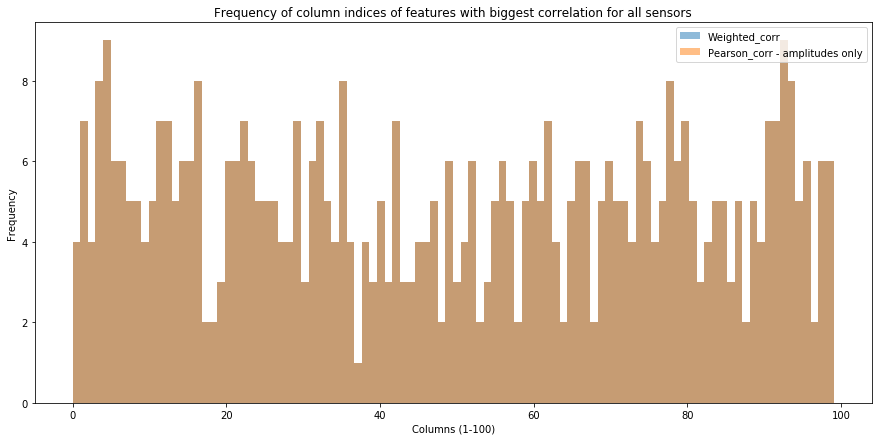

In [74]:

    bins = sorted_values__amp_from_all_sensors[0].shape[1]
    plt.figure(figsize=(15,7))
    plt.hist(feature_n_w, bins, alpha=0.5, label='Weighted_corr')
    plt.hist(feature_n, bins, alpha=0.5, label='Pearson_corr - amplitudes only')
    plt.xlabel("Columns (1-100)")
    plt.ylabel("Frequency")
    plt.title("Frequency of column indices of features with biggest correlation for all sensors")
    plt.legend(loc='upper right')
    plt.show()



Representation of sensors in percentages for each tral has been given  in the list percentage_w:

In [75]:
def MC_plot2(runs):
    bins = len(sensor)
    plt.figure(figsize=(15,7))
    plt.hist(sensor_n, bins, alpha=0.5, label='Pearson_corr - amplitudes only')
    plt.xlabel("Sensor (0-10)")
    plt.ylabel("Frequency") 
    plt.title("Frequency of sensor indices of features with biggest correlation ")
    plt.hist(sensor_n_x[runs], bins, alpha=0.5, label='Monte Carlo: Pearson_corr')
    plt.hist(sensor_n_w, bins, alpha=0.5, label='Weighted_corr')
    plt.legend(loc='upper right')
    plt.show()
interact(MC_plot2,runs=widgets.IntSlider(min=0, max=99, step=1))

interactive(children=(IntSlider(value=0, description='runs', max=99), Output()), _dom_classes=('widget-interac…

<function __main__.MC_plot2(runs)>

From these histograms and percentages, conclusion about how valuable is each of the sensors for this kind of prediction. Differences in contributions are visualised in a bar chart.

In [76]:
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['font.size'] = 9.0
labels = 'Microphone','Vibration plain bearing','Vibration piston rod','Vibration ball bearing', 'Axial force','Pressure','Velocity','Active current','Motor current phase 1','Motor current phase 2','Motor current phase 3'
print("Percentages of features from each sensor are:")

def Pie_MC(trials):   

    fig1,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,10))
   
    ax1.pie(percentage, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    ax1.legend(title="Pearson_corr - amplitudes only")
    ax2.pie(percentage_w,labels=labels, autopct='%1.1f%%', shadow=True, startangle=90 )
    ax2.axis('equal')
    ax2.legend(title="Weighted_corr")
    ax3.pie(percentage_x[trials], labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax3.axis('equal')
    ax3.legend(title="Monte Carlo: Pearson_corr")
# plot each pie chart in a separate subplot

    plt.show()
interact(Pie_MC,trials=widgets.IntSlider(min=0, max=99, step=1))

Percentages of features from each sensor are:


interactive(children=(IntSlider(value=0, description='trials', max=99), Output()), _dom_classes=('widget-inter…

<function __main__.Pie_MC(trials)>

A value of M, the number of Monte Carlo trials, i.e. the number of model evaluations to be made, needs to be selected. 
A value of M = $10^6$ can often be expected to deliver a 95 % coverage interval for the output quantity such that this length is correct to one or two signiﬁcant decimal digits.  
The choice of avalue of M that is large compared with 1/(1−p), e.g. M at least $10^4$ times greater than 1/(1−p), should be made (p-coverage interval). 
The average:

 $$\hat{y_r}=\frac{1}{M}*\sum_{i=1}^r y_r$$
and standard deviation u($\hat{y_r}$) determined from  u²($\hat{y_r}$) =$\frac{1}{M-1}*\sum_{i=1}^r (y_r-\hat{y_r})²$ are taken, respectively, as an estimate y of Y and the standard uncertainty u(y) associated with y.


In the case of function *largest_indices* whose outputs are sensor and column indices of features with highest Pearson correlation, the of frequency of occurence of every sensor in M MC trials has been calculated and stored in `sensor_count_MC`.
`mean_val` and `std_val` calculate the average and standard deviation of sensor occurences in all trials.


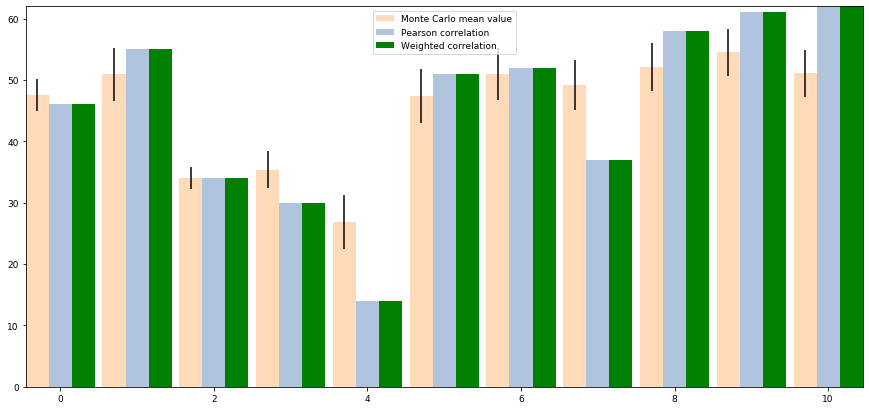

In [77]:
sensor_count_MC=np.zeros((trials,len(sensor)))
sensor_count_Pear=np.zeros((len(sensor)))
sensor_count_Weighted=np.zeros((len(sensor)))
for a in range(trials):
    #counting the frequency of occurences for every sensor in trial and storing in  sensor_count_MC list.
    sensor_count_MC[a,:]=np.bincount(sensor_n_x[a], weights=None, minlength=0)

sensor_count_df=pd.DataFrame(sensor_count_MC)
mean_val=sensor_count_df.mean(axis=0)
std_val=sensor_count_df.std(axis=0)
#counting the frequency of occurences for every sensor for two others methods.
sensor_count_Pear=np.bincount(sensor_n, weights=None, minlength=0)
sensor_count_Weighted=np.bincount(sensor_n_w, weights=None, minlength=0)

plt.figure(figsize=(15,7))
ax = plt.subplot(111)

w = 0.3
ax.bar(np.arange(11)-w,mean_val,yerr=std_val, width=w, color='peachpuff', align='center',label="Monte Carlo mean value")
ax.bar(np.arange(11), sensor_count_Pear,width=w, color='lightsteelblue', align='center',label="Pearson_corr - amplitudes only")
ax.bar(np.arange(11)+w, sensor_count_Weighted, width=w, color='g', align='center',label="Weighted correlation")

ax.autoscale(tight=True)
plt.legend()

plt.show()


We can also visualise some of the features, and see how they are correlated to each other and to the target vector.  

In [84]:
x1, x2 = input("Enter indices of two features out of %s for ploting (0-499): " % n_of_features).split()
x1, x2 = [int(x1), int(x2)]
def Compare_two(trials): 

    plt.subplot
 
    plt.figure(figsize=(12,6))
    plt.scatter(abs_top_n_together_matrix[x1], abs_top_n_together_matrix[x2],c=target_train_vector[0], cmap="viridis")
    plt.xlabel('Feature number %s' % x1 ,fontsize=12)
    plt.title("Pearson_corr - amplitudes only")
    plt.ylabel('Feature number %s' % x2 ,fontsize=12)
    plt.colorbar().set_label('% of wear',fontsize=12 ,rotation=90)
    
    plt.subplot
    plt.title("Monte Carlo: Pearson_corr")
    plt.figure(figsize=(12,6))
    plt.scatter(abs_top_n_together_matrix_x[trials][x1], abs_top_n_together_matrix_x[trials][x2],c=target_train_vector[0], cmap="viridis")
    plt.xlabel('Feature number %s' % x1 ,fontsize=12)
    plt.ylabel('Feature number %s' % x2 ,fontsize=12)
    plt.colorbar().set_label('% of wear',fontsize=12 ,rotation=90)
    
    plt.subplot
    plt.title("Weighted_corr")
    plt.figure(figsize=(12,6))
    plt.scatter(abs_top_n_together_matrix_w[x1], abs_top_n_together_matrix_w[x2],c=target_train_vector[0], cmap="viridis")
    plt.xlabel('Feature number %s' % x1 ,fontsize=12)
    plt.ylabel('Feature number %s' % x2 ,fontsize=12)
    plt.colorbar().set_label('% of wear',fontsize=12 ,rotation=90)
interact(Compare_two,trials=widgets.IntSlider(min=0, max=99, step=1))

Enter indices of two features out of 500 for ploting (0-499): 55 56


interactive(children=(IntSlider(value=0, description='trials', max=99), Output()), _dom_classes=('widget-inter…

<function __main__.Compare_two(trials)>

### References:

[1]  PTB, ZeMA, - Deep dive into the ZeMA machine learning (ppt), January 2019

[2]  https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft

[3]  http://www.sthda.com/english/wiki/correlation-test-between-two-variables-in-r

[4]  https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

[5]  Edouard Duchesnay, Tommy Löfstedt, - Statistics and Machine Learning in Python, March 2018

[6]  https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html

[7]  Evaluation of measurement data — Supplement 1 to the “Guide to the expression of uncertainty in measurement” — Propagation      of distributions using a Monte Carlo method,  JCGM 101:2008 

[8]  S Eichstädt (PTB) - Material for a Monte Carlo Uncertainty workshop with Jupyter notebooks https://github.com/eichstaedtPTB/MonteCarloHandsOn                   

